In [15]:
import numpy as np
import pandas as pd
import gc; gc.enable()
import random, time, datetime

# VIZUALIZATION
import matplotlib.pyplot as plt # basic plotting
%matplotlib inline

np.random.seed(1122)

# Read datasets
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
items = pd.read_csv('../input/items.csv', dtype={'perishable':str})
stores = pd.read_csv('../input/stores.csv')
transactions = pd.read_csv('../input/transactions.csv', parse_dates=['date'])
holidays = pd.read_csv('../input/holidays_events.csv', dtype={'transferred':bool}, parse_dates=['date'])
oil = pd.read_csv('../input/oil.csv', parse_dates=['date'])

def print_dataframe_size(name, df):
    print("{}: {:.3f} MB".format(name, df.memory_usage(index=True).sum()/1E6))
    
def print_runtime(start, end):
    print("runtime: {}".format( datetime.timedelta(seconds=(end-start)/60)))

# Stores

In [16]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Store #52

This store is special because it was created very recently (2017-04-20). This poses problems regarding the creation of the lag features. It may require a particular treatment.

In [17]:
## Stores in Manta
stores[stores.city=='Manta']

,store_nbr,city,state,type,cluster
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13


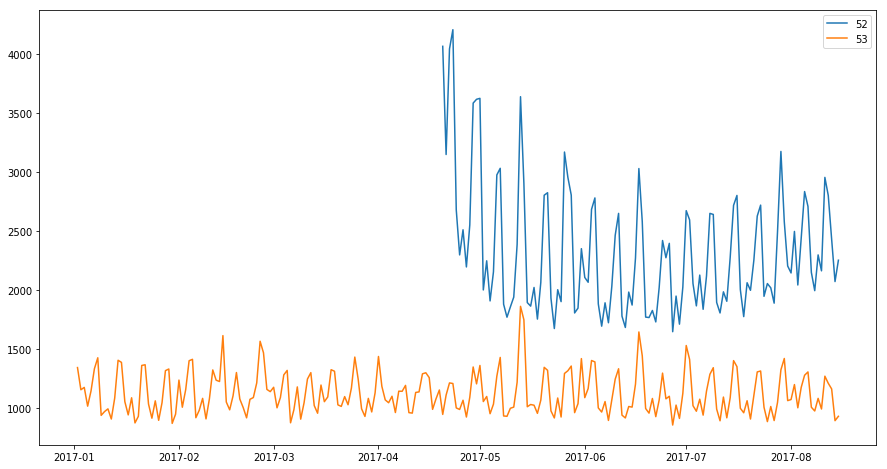

In [18]:
## Time series plot of the stores in Manta

a = transactions[transactions.store_nbr==52][['date', 'transactions']]
a_ts = pd.Series(a.transactions.values, index=a.date)

b = transactions[transactions.store_nbr==53][['date', 'transactions']]
b_ts = pd.Series(b.transactions.values, index=b.date)

plt.figure(figsize=(15,8))
plt.plot(a_ts, label='52');
plt.plot(b_ts['2017'], label='53');
plt.legend()

In [19]:
## Check Correlation coefficient of the stores in Manta
tmp = a.merge(b, on='date', how='left')
tmp[['transactions_x','transactions_y']].corr()

,transactions_x,transactions_y
transactions_x,1.000000,0.683396
transactions_y,0.683396,1.000000


They are not strongly correlated because of the special nature of Store #52

In [20]:
## Look for the store more correlated with store #52

s52 = transactions[transactions.store_nbr==52][['date', 'transactions']]

cl = []

for s in stores.store_nbr.unique():
    #print(s)
    if (s==52):
        continue
    
    b = transactions[transactions.store_nbr==s][['date', 'transactions']]
    tmp = s52.merge(b, on='date', how='left')
    r2 = tmp[['transactions_x','transactions_y']].corr().iloc[0,1]
    cl.append((s,r2))

[a for a in cl if a[1]>0.7]

[(27, 0.71990205548515851),
 (38, 0.74240045250585529),
 (45, 0.72796957091425585),
 (46, 0.76411215459267168),
 (47, 0.74678872671813701),
 (48, 0.74749562554290949),
 (50, 0.71354499367866975)]

In [21]:
stores[stores.store_nbr==46]

,store_nbr,city,state,type,cluster
45,46,Quito,Pichincha,A,14


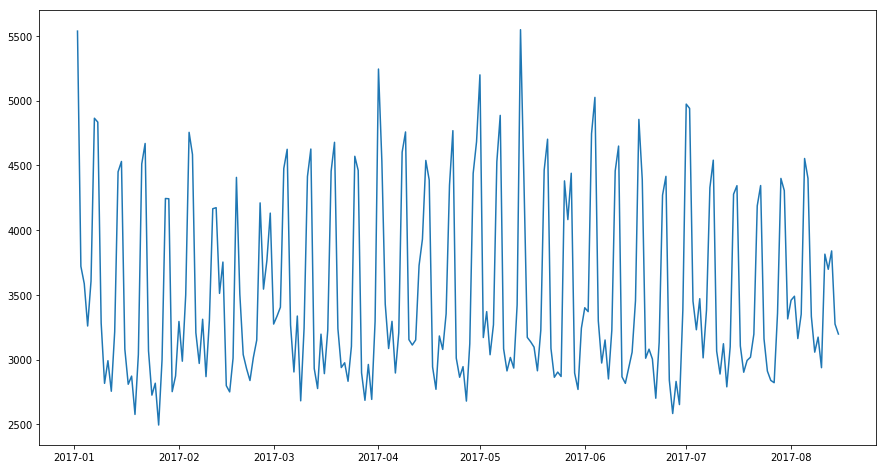

In [8]:
a = transactions[transactions.store_nbr==46][['date', 'transactions']]
a_ts = pd.Series(a.transactions.values, index=a.date)

plt.figure(figsize=(15,8))
plt.plot(a_ts['2017'], label='46');

A store in Quito is the most correlated to store #52 (R2: 0.76). Both of them are type A

In [30]:
# Weekly trend
s52['dow'] = s52.date.dt.dayofweek

w_trend = s52.groupby('dow').transactions.mean()
w_trend

dow
0    2118.058824
1    1892.588235
2    2103.937500
3    2045.823529
4    2380.529412
5    2948.000000
6    2834.411765
Name: transactions, dtype: float64

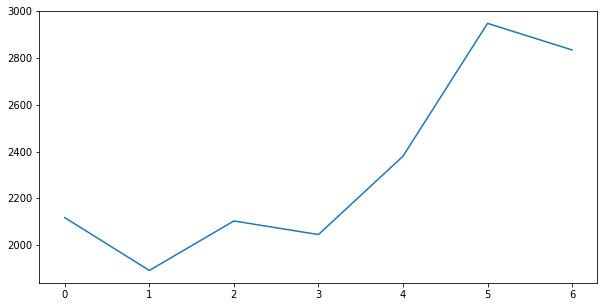

In [26]:
ts = pd.Series(w_trend.values)
plt.figure(figsize=(10,5))
plt.plot(ts, label='Weekly trend')

# Items

In [10]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [11]:
items['perishable_w'] = items['perishable'].map({False:1.0, True:1.25}) 
items.head()

,item_nbr,family,class,perishable,perishable_w
0,96995,GROCERY I,1093,0,NaN
1,99197,GROCERY I,1067,0,NaN
2,103501,CLEANING,3008,0,NaN
3,103520,GROCERY I,1028,0,NaN
4,103665,BREAD/BAKERY,2712,1,NaN


# Holidays

In [12]:
holidays.loc[lambda df: (df.description.str.contains('Independencia de Guayaquil')),]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
190,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
274,2016-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
